# A Simple Benchmark of the Edge-Sampling Model

In [1]:
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '-1'
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2' 
import tensorflow as tf
import logging
tf.get_logger().setLevel(logging.ERROR)
logging.getLogger("tensorflow").setLevel(logging.ERROR)
import model
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx


%load_ext autoreload
%autoreload 2

1 Physical GPUs, 1 Logical GPUs


## Finding a Node in a Graph

Here we generate a single graph, select one node as the target where all walkers should gather.
Here, we implement the state model as the identity model and apply the GAT-Attention mechanism for the neighborhood sampling.

### Random Graph Generator

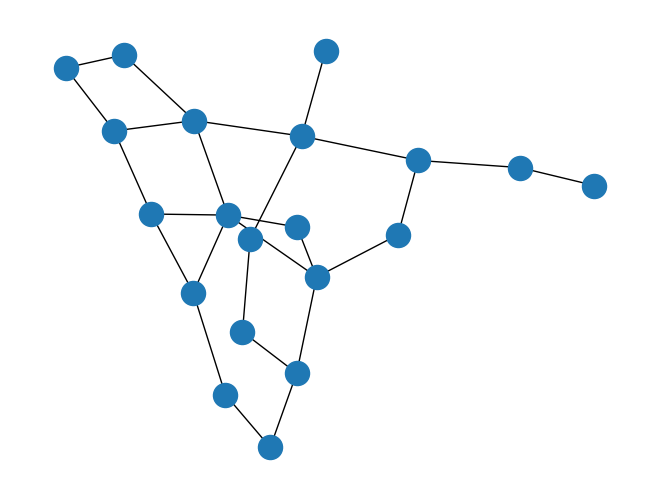

In [2]:
def generate_connected_graph(n_nodes, edge_frac, duplicate_edges=False):
    '''
    This function generates connected graphs randomly, where `edge_frac`
    is the ration of edges in the graph w.r.t. the fully connected version:
    `edge_frac = n_edges / n_nodes**2`.
    '''
    g = nx.grid_graph((n_nodes,))

    g_edge_frac = len(g.edges) / n_nodes**2
    missing_edges = int((edge_frac - g_edge_frac) * n_nodes**2)

    if missing_edges <= 0:
        return g

    edge_pool = set(zip(
        np.repeat(np.arange(n_nodes), n_nodes, axis=0),
        np.tile(np.arange(n_nodes), [n_nodes])
    ))

    if duplicate_edges:
        edge_pool = edge_pool - set(g.edges)

    add_edges = np.random.choice(len(edge_pool), size=missing_edges)
    g.add_edges_from(list(np.asarray(list(edge_pool))[add_edges]))
    return g

graph = generate_connected_graph(20, 0.07)
nx.draw(graph)

### Generate the Data

 * node features are unique one-hot vectors
 * features of the target node are a vector of ${-1}^d$
 * here we specify node 5 as the target node
 * node feature dimensionality $d$ is equal to the number of nodes

In [3]:
graph = graph.to_directed()
target_node = 5
num_nodes = graph.number_of_nodes()
n_features = num_nodes

target_node_feats = np.ones([n_features]) * -1
features = np.eye(num_nodes)[:,:n_features]
features[target_node] = target_node_feats
edge_index = np.stack(graph.edges)
mask = np.ones([num_nodes, 1], dtype=np.int32)

### Define a simple State Model

In this notebook we are looking at the sampling model only. The state model simply returns its input as the current state and output.

In [4]:
class SimpleStateModel(tf.keras.layers.Layer):
    
    def __init__(self, units):
        super(SimpleStateModel, self).__init__()
        self.units = units

    def call(self, x, hidden_state, training=False):
        return x, x

### Define a DSGNN-Cell and DSGNN Model

Just like an RNN, DSGNN is implemented by defining a cell. The cell implements the logic that is executed per step. It inherits from `DSGNNCellBase` and is passed to the `DSGNN` which calls it iteratively for a number of sampling steps.
 * Define the edge-selection model `att`
 * Define the sampler (Implements the ST-Gumbel-Softmax; unparameterized)
 * Define the state model (using the simple class defined above)
 * Create a cell which uses the above components

In [5]:
import model.base_model

attention_model_config = {
    'units' : 32,
    'dropout' : 0.5
}
sampling_model_config = {
    'temperature' : 0.6,
}

att = model.attention_models.GATAttention(**attention_model_config)
sampler = model.gumbel.GumbelSampling(**sampling_model_config)
state_model = SimpleStateModel(n_features) # model.state_models.ResidualBlock(n_features) # SimpleStateModel(n_features)

cell = model.dsgnn_cells.SimpleDSGNNCell(
    att, sampler, walkers_per_node=1, state_model=state_model, 
    max_walkers_per_node=1, identify_walkers_per_node=False
)
m = model.base_model.DSGNN(
    cell, walker_state_size=n_features, pooling_level=None
)

### Build the TensorFlow `tf.data` pipeline

In [6]:
from data.dataset import to_tf_dataset, batch_graph
from functools import partial

def train_generator(n_samples=1e4, random_features=False, random_targets=False):
    target_nodes = [target_node] * int(n_samples)
    
    if random_targets:
        target_nodes = np.random.randint(num_nodes, size=n_samples)
    
    for tid in target_nodes:
        if random_features:
            features = np.random.uniform(size=[num_nodes, n_features])
        else:
            features = np.eye(num_nodes)[:,:n_features]
        # change the features of the target node 
        features[tid] = target_node_feats
        
        yield {
            'node_features' : features.astype(np.float32),
            'edge_index' : edge_index.astype(np.int32),
            'num_nodes' : num_nodes,
        }, {
            'labels' : target_node_feats[tf.newaxis].repeat(num_nodes, axis=0).astype(np.float32)
        }

train_gen = partial(batch_graph, train_generator, 32)
train_gen = partial(to_tf_dataset, train_gen, selfloops=True)

### Model Training

Pass the training data generator. The objective in this case is that the walker state is equal to the features of the target node. Because the state model only returns its input, reaching the target node is the only way to minimize the loss. We compute the `MAE` loss between walker state and target node features.

In [7]:
losses = []

In [8]:
n_steps = 10
op = tf.keras.optimizers.Adam(0.0001)

m.train(train_gen, 1, 'MAE', n_steps=n_steps, optimizer=op, 
        metrics_callback=lambda r: losses.append(r['non_sampling_model/loss']),
        train_separately=False
)

Training ACGNN for 1 epochs:   0%|                                                                            …

0it [00:00, ?it/s]

Text(0.5, 0, 'Training Step')

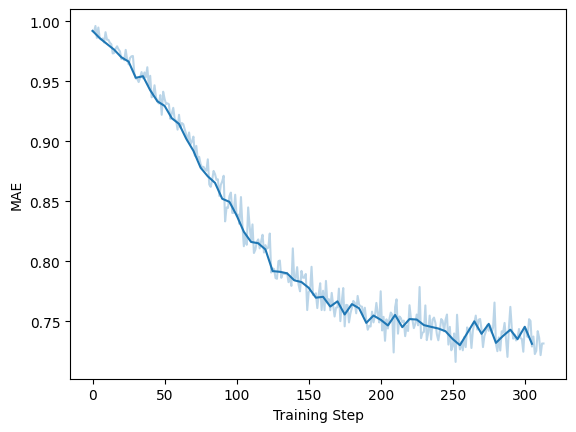

In [9]:
plt.plot(losses, alpha=0.3)
n_op_steps = len(losses)
lm = np.stack(losses)[:len(losses) // 5 * 5].reshape(-1, 5).mean(-1)
plt.plot(np.arange(0, len(lm)*5, 5), lm, color='C0')
plt.ylabel('MAE')
plt.xlabel('Training Step')

### Test the Model

In [10]:
test_gen = partial(batch_graph, train_generator, 1)
test_gen = partial(to_tf_dataset, test_gen, selfloops=True)

inp, labs = next(iter(test_gen()))

states, node_features, prediction, walker_output_states = m(
    (None, inp['node_features'], inp['edge_list'], inp['node_degrees'], None), 
    n_steps=n_steps, graph_mask=labs['graph_mask'], output_all_states=True
)

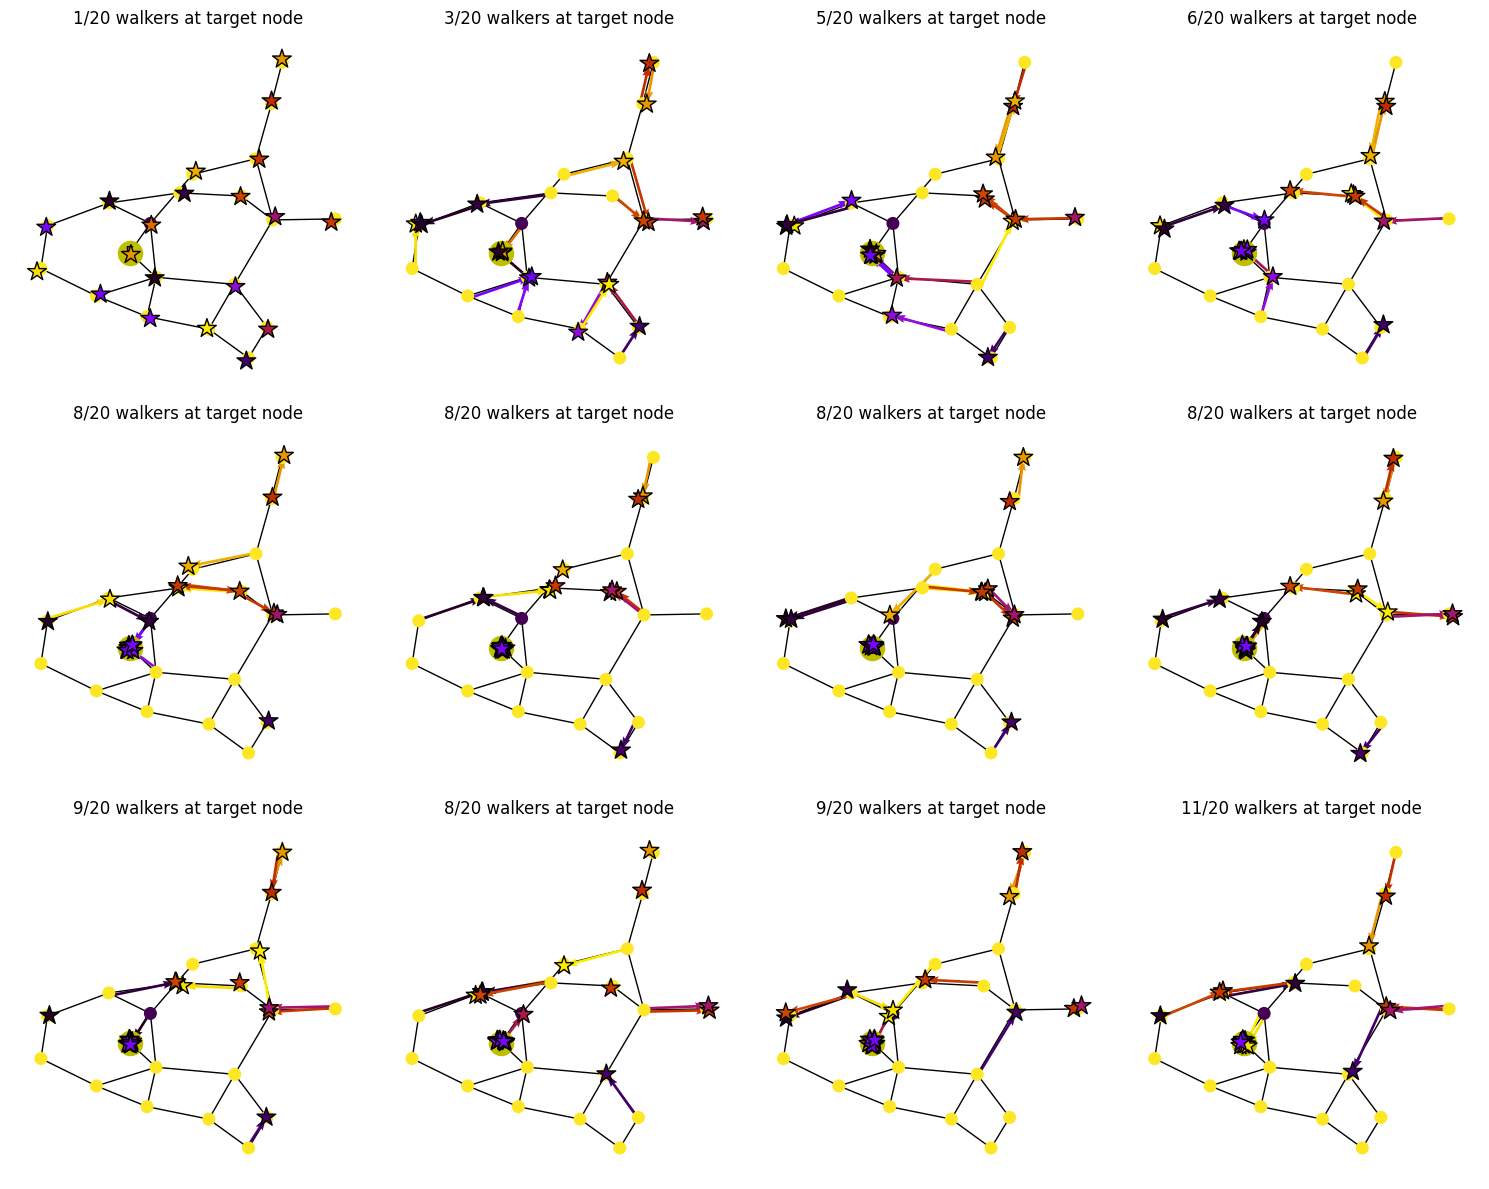

In [ ]:
import utils

n_steps = len(walker_output_states)
fig, ax = plt.subplots(n_steps//4, 4, figsize=(15, n_steps//4*4), tight_layout=True)

walker_colors = plt.cm.gnuplot(np.random.uniform(size=len(walker_output_states[0])))

last_steps = walker_output_states[0].numpy()
graph = nx.Graph(list(utils.graph_utils.edge_index_from_edge_list(inp['edge_list']).numpy()))
graph.remove_edges_from(nx.selfloop_edges(graph))
pos = nx.spring_layout(graph, seed=42)

for a, step_dist in zip(ax.flat, np.stack(walker_output_states)):
    node_colors = inp['node_features'].numpy().sum(-1)
    target_n = (inp['node_features'] == target_node_feats).numpy().all(-1).argmax()
    nx.draw_networkx(graph, pos=pos, ax=a, node_size=70, arrows=False, with_labels=False,
                    node_color=node_colors)
    nx.draw_networkx(nx.subgraph(graph, [target_n]), pos=pos, node_color='y', node_size=300, ax=a)
    a.axis('off')
    prev_pos = np.transpose([ pos[s] + np.random.uniform(-0.02, 0.02, 2) for s in last_steps ])
    w_pos = np.transpose([ pos[s] + np.random.uniform(-0.02, 0.02, 2) for s in step_dist ])
    a.scatter(*w_pos, color=walker_colors, zorder=100, marker='*', s=200, edgecolors='k')
    a.quiver(*prev_pos, *(w_pos-prev_pos), angles='xy', scale_units='xy', scale=1, color=walker_colors)
    n_arrived = sum(step_dist == target_n)
    a.set_title(f'{n_arrived}/{num_nodes} walkers at target node')
    last_steps = step_dist